# **目標：使用前三年的資產負債表裡的會計科目, 以及前兩年的綜合損益表及現金流量表裡的會計科目預測第四年年末的調整過後的稀釋每股盈餘數值**


## **資料時間**

訓練和驗證資料時間 x: (會採用cross validation)
1. 2012~2014年資產負債表科目
2. 2013~2014年的綜合損益表科目
3. 2013~2014年現金流量表科目

訓練和驗證資料時間 y :
1. 2015年的調整過後的稀釋每股盈餘

測試資料時間 x: 
1. 2013～2015年資產負債表科目
2. 2014~2015年的綜合損益表科目
3. 2014~2015年現金流量表科目

測試資料時間 y :
1. 2016年的調整過後的稀釋每股盈餘

## **標準化方法(共有兩種)**
1. 每間公司的當年度的資產負債表科目皆除以該公司當年度的資產總額, 當年度的綜合損益表以及現金流量表科目除以當年度的營業收入淨額, 每股盈餘相關欄位(即每股盈餘_調整, 每股盈餘-完全稀釋_調整這兩個欄位)除以第三年末的收盤價。在後面的程式碼中, 會以 total_asset 這個名稱來代稱這種標準化方法。


*   舉例來說: 台泥2012年的現金及約當現金需除以台泥2012年的資產總額, 台泥2013年的營業費用需除以台泥2013年的營業收入淨額, 台泥2013年的每股盈餘_調整需除以台泥2014年的收盤價(元)。

2. 除了每股盈餘相關的科目以外(即每股盈餘_調整, 每股盈餘-完全稀釋_調整這兩個欄位), 其餘科目皆除以第三年末實際流通在外股數, 接著再將所有欄位做機器學習標準化。在後面的程式碼中, 會以 stock_number 這個名稱來代稱這種標準化方法。

*   舉例來說: 台泥2012年, 2013年及2014年的現金及約當現金科目皆需除以台泥2014年的流通在外股數。

## **模型**
1. random forest regressor
2. xgboost regressor

## **判斷模型表現的指標**
1. RMSE。

## **綜上所述, 總共會跑四種不同的模型組合**
1. 標準化方法一(total_asset) 搭配 random forest regressor。
2. 標準化方法一 搭配 xgboost regressor。
3. 標準化方法二(stock number) 搭配 random forest regressor。
4. 標準化方法二 搭配 xgboost regressor。

模型訓練及預測完以後, 會再畫個別模型組合的feature importance以及展示各個模型組合的RMSE百分位。

環境：google colab

In [1]:
# 安裝套件
import pandas as pd
import numpy as np
import pickle
import copy
import timeit
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from matplotlib import cm
from pandas import ExcelWriter
from functools import reduce
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.3f' % x)
np.set_printoptions(suppress=True) # 不要顯示科學記號

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Acc_ML/data" 

Mounted at /content/drive
/content/drive/MyDrive/Acc_ML/data


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
#安裝在畫圖時中文顯示的字體
from matplotlib.font_manager import fontManager
# 如果下載字體失敗, 再重新下載一次就可以了
# !wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# **資料前處理**

一開始需要先載入欄位確認_final, 公司_產業_final以及每股盈餘這三個檔案。
1. 欄位確認_final: 紀錄每間公司從2012 - 2017年資產負債表, 綜合損益表, 現金流量表裡會計科目的值。(在這個excel檔裡, 資產負債表, 綜合損益表, 現金流量表是分成三個sheet紀錄的)
2. 公司_產業_final: 主要紀錄每間公司是屬於什麼產業。
3. 每股盈餘: 紀錄公司從2012 - 2017年的每股盈餘, 市值, 年末流通在外股數, 年末收盤價等資料。

資料中所使用的公司選擇的條件是：
1. 上市或上櫃
2. 不為金融業

In [5]:
# 將檔案載入
file_path = './欄位確認_final.xlsx' # 要更改成自己檔案的路徑
asset = pd.read_excel(file_path, sheet_name='資產負債表')
income = pd.read_excel(file_path, sheet_name='損益表')
cash = pd.read_excel(file_path, sheet_name='現金流量表')
company_industry = pd.read_excel('./公司_產業_final.xlsx')
eps_df = pd.read_excel('./每股盈餘.xlsx')

In [5]:
# 看一下eps_df的資料長相
eps_df[eps_df['公司'].str.contains("台泥")]

,公司,年月,每股盈餘,調整因子,市值(百萬元),流通在外股數(千股),收盤價(元)
359,1101 台泥,2012-12-28,2.110,0.809,143626.000,3692175.000,38.900
360,1101 台泥,2013-12-31,2.720,0.809,170763.000,3692175.000,46.250
361,1101 台泥,2014-12-31,2.930,0.809,160240.000,3692175.000,43.400
362,1101 台泥,2015-12-31,1.560,0.809,100796.000,3692175.000,27.300
363,1101 台泥,2016-12-30,1.720,0.809,129780.000,3692175.000,35.150
364,1101 台泥,2017-12-29,2.030,0.809,154785.000,4246509.000,36.450


In [ ]:
company_industry.head(3)

,公司簡稱,上市別,TEJ產業_名稱,TEJ產業_代碼,TEJ產業指數,TEJ產業名
0,000116 日盛證券,NaN,證券,M30A,TEJF03 金融- 證券投信業,M30A 證券
1,000930 華南永昌證券,NaN,證券,M30A,TEJF03 金融- 證券投信業,M30A 證券
2,000960 富邦證券,NaN,證券,M30A,TEJF03 金融- 證券投信業,M30A 證券


In [6]:
# 選取上市、上櫃且不為金融或證券業的公司
delete_industry = ['證券', '本國銀行', '產險業', '票券公司', '壽險業', '信託公司', '金融控股', '投信業', '證金公司', '投資業', '保險經紀', '期貨']
filter1 = (company_industry['上市別'].isin(['OTC', 'TSE']))
filter2 = (~company_industry['TEJ產業_名稱'].isin(delete_industry))
need_company = company_industry[filter1 & filter2]['公司簡稱']

In [7]:
# 將資產負債表, 綜合損益表, 現金流量表合併起來變成df_final這個檔案。
df = [asset, income, cash]
df_final = reduce(lambda left, right: pd.merge(left, right, on=['公司', '年月'], how='left'), df)
df_final = df_final[df_final['公司'].isin(need_company)]

In [ ]:
df_final.head(3)

,公司,年月,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,其他應收款,資金貸予他人－流動,存貨,待出售非流動資產,當期所得稅資產－流動,流動資產,透過損益按公允價值衡量之金融資產－非流動,透過其他綜合損益按公允價值衡量之金融資產－非流動,按攤銷後成本衡量之金融資產－非流動,避險之金融資產－非流動,合約資產－非流動,採權益法之長期股權投資,預付投資款,不動產廠房及設備,商譽及無形資產合計,遞延所得稅資產,遞延資產合計,使用權資產,投資性不動產淨額,其他非流動資產,非流動資產,資產總額,短期借款,應付商業本票∕承兌匯票,透過損益按公允價值衡量之金融負債－流動,避險之金融負債－流動,按攤銷後成本衡量之金融負債－流動,合約負債－流動,應付帳款及票據,其他應付款,當期所得稅負債,負債準備－流動,與待出售非流動資產直接相關之負債,租賃負債─流動,一年內到期長期負債,特別股負債－流動,流動負債,透過損益按公允價值衡量之金融負債－非流動,避險之金融負債－非流動,按攤銷後成本衡量之金融負債－非流動,合約負債－非流動,特別股負債－非流動,應付公司債－非流動,銀行借款－非流動,其他長期借款－非流動,租賃負債－非流動,負債準備－非流動,遞延貸項,應計退休金負債,遞延所得稅,非流動負債,負債總額,普通股股本,特別股股本,預收股款,待分配股票股利,換股權利證書,股本,資本公積合計,法定盈餘公積,特別盈餘公積,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,股東權益總額,負債及股東權益總額,營業收入淨額,營業成本,營業毛利,聯屬公司已（未）實現銷貨利益,已實現銷貨毛利,營業費用,研究發展費,預期信用減損（損失）利益－營業費用,其他收益及費損淨額,營業利益,利息收入,其他收入,其他利益及損失,財務成本,採權益法之關聯企業及合資損益之份額,預期信用減損（損失）利益,除列按攤銷後成本衡量金融資產淨損益,金融資產重分類淨損益,營業外收入及支出－其他,營業外收入及支出,稅前淨利,所得稅費用,繼續營業單位損益,停業單位損益,合併前非屬共同控制股權損益,其他損益調整項－非常項目及累計影響數,合併總損益,不重分類至損益之項目－OCI,後續可能重分類至損益之項目－OCI,合併前非屬共同控制股權綜合損益淨額－OCI,其他綜合損益－OCI,本期綜合損益總額,歸屬母公司淨利（損）,歸屬非控制權益淨利（損）,歸屬共同控制下前手權益淨利（損）,綜合損益歸屬母公司,綜合損益歸屬非控制權益,綜合損益歸屬共同控制下前手權益,每股盈餘,加權平均股數,發放特別股股息,稀釋稅後淨利,每股盈餘－完全稀釋,加權平均股數－稀釋,稅前息前淨利,稅前息前折舊前淨利,常續性稅後淨利,稅前淨利－CFO,折舊－CFO,攤提－CFO,來自營運之現金流量,新增投資－CFI,出售投資－CFI,購置不動產廠房設備（含預付）－CFI,處分不動產廠房設備（含預付）－CFI,投資活動之現金流量,現金增（減）資－CFF,支付現金股利－CFF,籌資活動之現金流量,匯率影響數,本期產生現金流量,期初現金及約當現金,期末現金及約當現金
30,1101 台泥,2012-12-28,25611406000.000,148527000.000,15751741000.000,0.000,206000.000,0.000,19498993000.000,2143543000.000,1220456000.000,9645715000.000,0.000,0.000,80534379000.000,616193000.000,4534843000.000,0.000,0.000,NaN,7181369000.000,6408525000.000,104289140000.000,17282511000.000,317273000.000,317273000.000,NaN,5874323000.000,52784253000.000,193414107000.000,273948486000.000,18945086000.000,4912171000.000,167000.000,10746000.000,NaN,2267023000.000,7880074000.000,9162750000.000,1266913000.000,0.000,0.000,NaN,21693156000.000,0.000,66990199000.000,24989000.000,38554000.000,NaN,NaN,0.000,3500000000.000,51367579000.000,0.000,NaN,0.000,0.000,332765000.000,9321578000.000,65151947000.000,132142146000.000,36921759000.000,0.000,0.000,0.000,0.000,36921759000.000,12215684000.000,9952623000.000,13060950000.000,21094539000.000,44108112000.000,12716255000.000,0.000,105961810000.000,0.000,0.000,35844530000.000,141806340000.000,273948486000.000,113699313000.000,95950845000.000,17748468000.000,0.000,17748468000.000,4541914000.000,33105000.000,NaN,0.000,13206554000.000,213321000.000,1938355000.000,-1310040000.000,2723582000.000,1009601000.000,NaN,NaN,NaN,0.000,-1085666000.000,12120888000.000,2122669000.000,9998219000.000,0.000,0.000,0.000,9998219000.000,-339859000.000,2321793000.000,NaN,1981934000.000,11980153000.000,7784265000.000,2213954000.000,0.000,10232450000.000,1747703000.000,0.000,2.110,3692176.000,0.000,NaN,NaN,NaN,14844470000.000,21304303000.000,9297087000.000,12120888000.000,6108714000.000,351119000.000,25434756000.000,-5974267000.000,234992000.000,-5914763000.000,467285000.000,-9932035000.000,0.000,-9326896000.000,-12251656000.000,220073000.000,3471138000.000,22140268000.000,25611406000.000
31,1101 台泥,2013-12-31,25711065000.000,215182000.000,19165866000.000,0.000,11810000.000,0.000,25597371000.000,1539157000.000,244277000.000,9286227000.000,0.000,0.000,87788055000.000,579192000.000,4551126000.000,0.000,0.000,NaN,8028252000.000,0.000,109369671000.000,19495931000.000,610210000.000,610210000.000,NaN,6045488000.000,52258302000.000,194892684000.000,282680739000.000,18521893000.000,5102283000.000,0.000,13477000.000,NaN,2630423000.000,8428309000.000,9793971000.000,1899948000.000,0.000,0.000,NaN,23658417000.000,0.000,70398494000.000,22213000.000,0.000,NaN,NaN,0.000,0.000,47342350000.000,0.000,NaN,0.000,0.000,303577000.000,9679623000.000,58663668000.000,129062162000.000,36921759000.000,0.000,0.000,0.000,0.000,36921759000.000,12193297000.000,10726105000.000,13051193000.000,23488214000.000,47265512000.000,16697377000.000,0.000,113077945000.000,0.000,0.000,405406320

In [8]:
# 將一些會用到的欄位的值變回原本的單位, 例如：股數的部分他都是以千股的方式顯示, 也就是乘以1000才會變回原本的值。
eps_df['流通在外股數'] = eps_df['流通在外股數(千股)']*1000
df_final['加權平均股數'] = df_final['加權平均股數']*1000
df_final['加權平均股數－稀釋'] = df_final['加權平均股數－稀釋']*1000

# 再將df_final與eps_df以公司和年月這兩個欄位的值做合併(取交集)。
df_final = df_final.merge(eps_df[['公司', '年月', '調整因子', '收盤價(元)', '流通在外股數']], on=['公司', '年月'], how='inner')

In [9]:
# 為了讓每股盈餘可以跨年度比較, 所以乘上調整因子, 之後模型要預測的即是"每股盈餘－完全稀釋_調整"這個欄位。
df_final['每股盈餘_調整'] = df_final['每股盈餘']*df_final['調整因子']
df_final['每股盈餘－完全稀釋_調整'] = df_final['每股盈餘－完全稀釋']*df_final['調整因子']

In [10]:
# 因為有些公司在某些年度會沒有資料, 所以建立year_data這個matrix, 用來記錄公司在哪幾年是有資料的
all_company_list = list(df_final.公司.unique())
year = ['2012-12-28', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-30', '2017-12-29']
# year_data: 先建立一個公司總數(1717)*年份長度(從2012-2017年, 共6年)的matrix, 值都先填0
year_data = np.zeros(shape=(len(all_company_list), len(year)))

# 用for loop繞過每間公司, 把該間公司有資料的年份所對應的位置填1, 沒有資料的年份則維持填0
for j in range(len(all_company_list)):
  tmp = df_final[df_final['公司']==all_company_list[j]]
  tmp1 = tmp['年月'].values
  tmp3 = np.zeros(shape=(len(year)))
  
  for i in range(tmp.shape[0]):
    if tmp3[int(str(tmp1[i])[3])-2] == 1:
        print('年份重複:', all_company_list[j])
    tmp3[int(str(tmp1[i])[3])-2] = 1
    year_data[j, :] = tmp3

In [ ]:
# year_data的長相
pd.DataFrame(year_data, index=all_company_list, columns=year)

,2012-12-28,2013-12-31,2014-12-31,2015-12-31,2016-12-30,2017-12-29
1101 台泥,1.000,1.000,1.000,1.000,1.000,1.000
1102 亞泥,1.000,1.000,1.000,1.000,1.000,1.000
1103 嘉泥,1.000,1.000,1.000,1.000,1.000,1.000
1104 環泥,1.000,1.000,1.000,1.000,1.000,1.000
1108 幸福,1.000,1.000,1.000,1.000,1.000,1.000
...,...,...,...,...,...,...
9951 皇田,1.000,1.000,1.000,1.000,1.000,1.000
9955 佳龍,1.000,1.000,1.000,1.000,1.000,1.000
9958 世紀鋼,1.000,1.000,1.000,1.000,1.000,1.000
9960 邁達康,1.000,1.000,1.000,1.000,1.000,1.000


In [ ]:
# 透過describe的功能可以看出哪些欄位缺值較多, 以及各欄位的平均值和標準差等。
df_final.describe()

,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,其他應收款,資金貸予他人－流動,存貨,待出售非流動資產,當期所得稅資產－流動,流動資產,透過損益按公允價值衡量之金融資產－非流動,透過其他綜合損益按公允價值衡量之金融資產－非流動,按攤銷後成本衡量之金融資產－非流動,避險之金融資產－非流動,合約資產－非流動,採權益法之長期股權投資,預付投資款,不動產廠房及設備,商譽及無形資產合計,遞延所得稅資產,遞延資產合計,使用權資產,投資性不動產淨額,其他非流動資產,非流動資產,資產總額,短期借款,應付商業本票∕承兌匯票,透過損益按公允價值衡量之金融負債－流動,避險之金融負債－流動,按攤銷後成本衡量之金融負債－流動,合約負債－流動,應付帳款及票據,其他應付款,當期所得稅負債,負債準備－流動,與待出售非流動資產直接相關之負債,租賃負債─流動,一年內到期長期負債,特別股負債－流動,流動負債,透過損益按公允價值衡量之金融負債－非流動,避險之金融負債－非流動,按攤銷後成本衡量之金融負債－非流動,合約負債－非流動,特別股負債－非流動,應付公司債－非流動,銀行借款－非流動,其他長期借款－非流動,租賃負債－非流動,負債準備－非流動,遞延貸項,應計退休金負債,遞延所得稅,非流動負債,負債總額,普通股股本,特別股股本,預收股款,待分配股票股利,換股權利證書,股本,資本公積合計,法定盈餘公積,特別盈餘公積,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,股東權益總額,負債及股東權益總額,營業收入淨額,營業成本,營業毛利,聯屬公司已（未）實現銷貨利益,已實現銷貨毛利,營業費用,研究發展費,預期信用減損（損失）利益－營業費用,其他收益及費損淨額,營業利益,利息收入,其他收入,其他利益及損失,財務成本,採權益法之關聯企業及合資損益之份額,預期信用減損（損失）利益,除列按攤銷後成本衡量金融資產淨損益,金融資產重分類淨損益,營業外收入及支出－其他,營業外收入及支出,稅前淨利,所得稅費用,繼續營業單位損益,停業單位損益,合併前非屬共同控制股權損益,其他損益調整項－非常項目及累計影響數,合併總損益,不重分類至損益之項目－OCI,後續可能重分類至損益之項目－OCI,合併前非屬共同控制股權綜合損益淨額－OCI,其他綜合損益－OCI,本期綜合損益總額,歸屬母公司淨利（損）,歸屬非控制權益淨利（損）,歸屬共同控制下前手權益淨利（損）,綜合損益歸屬母公司,綜合損益歸屬非控制權益,綜合損益歸屬共同控制下前手權益,每股盈餘,加權平均股數,發放特別股股息,稀釋稅後淨利,每股盈餘－完全稀釋,加權平均股數－稀釋,稅前息前淨利,稅前息前折舊前淨利,常續性稅後淨利,稅前淨利－CFO,折舊－CFO,攤提－CFO,來自營運之現金流量,新增投資－CFI,出售投資－CFI,購置不動產廠房設備（含預付）－CFI,處分不動產廠房設備（含預付）－CFI,投資活動之現金流量,現金增（減）資－CFF,支付現金股利－CFF,籌資活動之現金流量,匯率影響數,本期產生現金流量,期初現金及約當現金,期末現金及約當現金,調整因子,收盤價(元),流通在外股數,每股盈餘_調整,每股盈餘－完全稀釋_調整
count,9988.000,9988.000,9988.000,9988.000,9988.000,10019.000,9988.000,9988.000,9891.000,9988.000,9988.000,10019.000,10020.000,9988.000,9988.000,9988.000,9988.000,0.000,9988.000,9988.000,10019.000,9988.000,9988.000,9988.000,0.000,9988.000,9988.000,10019.000,10020.000,9988.000,9988.000,9988.000,9988.000,0.000,10019.000,9988.000,9988.000,9988.000,10019.000,9988.000,0.000,9988.000,9988.000,10020.000,9988.000,9988.000,0.000,2.000,9988.000,9988.000,9988.000,9988.000,0.000,9988.000,9988.000,9988.000,9988.000,10019.000,10020.000,10020.000,9990.000,9990.000,9990.000,9989.000,10020.000,10009.000,9975.000,9975.000,10007.000,9989.000,9989.000,9992.000,10020.000,10003.000,10003.000,9916.000,10020.000,10020.000,9989.000,9984.000,9989.000,9959.000,9989.000,9985.000,9606.000,15.000,9970.000,9989.000,9897.000,9960.000,9957.000,9958.000,9957.000,1.000,0.000,0.000,9989.000,9986.000,9989.000,9986.000,9988.000,9961.000,9988.000,9986.000,9989.000,9808.000,9810.000,6791.000,9808.000,9811.000,9989.000,9985.000,9988.000,9811.000,9811.000,9808.000,9974.000,9968.000,9986.000,8416.000,8416.000,8417.000,9958.000,9956.000,9988.000,9989.000,9957.000,9957.000,9957.000,9957.000,9957.000,9957.000,9957.000,9957.000,9957.000,9957.000,9957.000,9957.000,9957.000,9957.000,9957.000,9959.000,9178.000,9178.000,9913.000,8364.000
mean,2956249697.737,129686579.596,328259963.156,116616374.449,1035952.243,54156996.307,2935140544.553,197645186.324,58418369.427,2379945791.550,26870674.309,5335178.062,10191896150.200,125027233.580,574604830.697,311411077.093,180842.811,NaN,906646770.925,3225096.416,5266838777.523,649148222.467,178827188.326,179091880.757,NaN,531647351.722,1050389705.647,9069080240.044,19260075624.152,1691337589.007,242668324.790,9597537.145,3233973.068,NaN,233934334.864,2231823685.423,970557300.060,136301325.090,70886075.856,11731908.490,NaN,591640550.961,311312.375,6823259768.164,5609824.289,1018884.361,NaN,12132500.000,2710069.383,594189248.999,1686362385.262,54969710.853,NaN,576984336.404,2336089.007,152327136.163,222324105.026,3448278558.439,10271201864.172,3282137202.096,14655400.100,895341.141,4004.004,161098.208,3297805976.048,1398875961.435,899594656.341,446738963.609,2139453450.185,3486858404.745,242651319.351,-67317353.183,8347976715.070,1103539.438,14892.732,646490592.174,8988873759.880,19260075624.152,17019201028.531,14543141780.950,2483303073.681,10494.126,2483313536.290,1531192791.487,362176481.054,-1856866.667,3499402.909,956216420.763,54334002.223,142409113.956,28329870.744,91747945.873,76808912.926,-37765000.000,NaN,NaN,-27780.759,15544

# **建構要放入模型的資料**

In [11]:
# 一開始載入的欄位確認_final中有很多的科目, 以下各個list紀錄等會會使用到的各個財務報表的欄位。
# 已經有先踢除掉一些整欄都是null的欄位了。
# asset_col:資產負債表科目欄位
asset_col = ['現金及約當現金', '透過損益按公允價值衡量之金融資產－流動', '透過其他綜合損益按公允價值衡量之金融資產－流動',
             '按攤銷後成本衡量之金融資產－流動', '避險之金融資產－流動', '合約資產－流動', '應收帳款及票據', '其他應收款',
             '資金貸予他人－流動', '存貨', '待出售非流動資產', '當期所得稅資產－流動', '流動資產', '透過損益按公允價值衡量之金融資產－非流動',
             '透過其他綜合損益按公允價值衡量之金融資產－非流動', '按攤銷後成本衡量之金融資產－非流動', '避險之金融資產－非流動', '採權益法之長期股權投資', 
             '預付投資款', '不動產廠房及設備', '商譽及無形資產合計', '遞延所得稅資產', '遞延資產合計',  '投資性不動產淨額', '其他非流動資產',
             '非流動資產', '資產總額', '短期借款', '應付商業本票∕承兌匯票', '透過損益按公允價值衡量之金融負債－流動', '避險之金融負債－流動',
             '合約負債－流動', '應付帳款及票據', '其他應付款', '當期所得稅負債', '負債準備－流動', '與待出售非流動資產直接相關之負債', 
             '一年內到期長期負債', '流動負債', '透過損益按公允價值衡量之金融負債－非流動', '避險之金融負債－非流動', '特別股負債－非流動', 
             '應付公司債－非流動', '銀行借款－非流動', '其他長期借款－非流動', '負債準備－非流動', '遞延貸項', '應計退休金負債', '遞延所得稅',
             '非流動負債', '負債總額', '普通股股本', '特別股股本', '預收股款',  '換股權利證書', '股本', '資本公積合計', '法定盈餘公積', 
             '特別盈餘公積', '未分配盈餘', '保留盈餘', '其他權益', '庫藏股票帳面值', '母公司股東權益合計', '共同控制下前手權益',  '非控制權益',
             '股東權益總額', '負債及股東權益總額']

# income_col:綜合損益表欄位
income_col = ['營業收入淨額', '營業成本', '營業毛利', '聯屬公司已（未）實現銷貨利益', '已實現銷貨毛利', '營業費用', '研究發展費', 
              '其他收益及費損淨額', '營業利益', '利息收入', '其他收入', '其他利益及損失', '財務成本', '採權益法之關聯企業及合資損益之份額',
              '營業外收入及支出', '稅前淨利', '所得稅費用', '繼續營業單位損益', '停業單位損益', '合併總損益', '不重分類至損益之項目－OCI',
              '後續可能重分類至損益之項目－OCI', '其他綜合損益－OCI', '本期綜合損益總額', '歸屬母公司淨利（損）', '歸屬非控制權益淨利（損）',
              '歸屬共同控制下前手權益淨利（損）', '綜合損益歸屬母公司', '綜合損益歸屬非控制權益', '綜合損益歸屬共同控制下前手權益', '加權平均股數',
              '稀釋稅後淨利', '加權平均股數－稀釋', '稅前息前淨利', '稅前息前折舊前淨利', '常續性稅後淨利']

# cash_col:現金流量表欄位(收盤價和流通在外股數會先納入, 以方便後面做標準化, 但資料進到模型前, 會再將這兩個欄位移除)
cash_col = ['來自營運之現金流量', '投資活動之現金流量', '籌資活動之現金流量', '收盤價(元)', '流通在外股數']

# eps_col: 每股盈餘相關欄位
eps_col = ['每股盈餘_調整', '每股盈餘－完全稀釋_調整']

# y_col: 最終要預測的欄位
y_col = ['每股盈餘－完全稀釋_調整']

In [12]:
# 建構要放入模型的資料
# 註解是以2012-2014去預測2015為例
# asset_start: 資產負債表開始的年份(2012), asset_end: 資產負債表結束的年份(2014)
# income_start: 綜合損益表開始的年份(2013), income_end: 綜合損益表結束的年份(2014)

def create_data(asset_col, income_col, cash_col, eps_col, y, df_final, asset_start, asset_end, income_start, income_end):
  # tmp_df = 將df_final轉變成每一列為一間公司, 每一個column為年份搭配會計科目 ex.(現金及約當現金, '2012-12-28')
  tmp_df = df_final.pivot(index='公司', columns='年月')
  year_index = asset_end + 1
  asset_start = asset_start - 2012
  asset_end = asset_end - 2012 + 1
  income_start = income_start - 2012
  income_end = income_end - 2012 + 1

  # 確認哪些公司在2012-2014年是有資料的
  company_name = np.array(all_company_list)[np.where(np.sum(year_data[:, asset_start:asset_end], axis=1) == 3)[0]]
  
  # 從tmp_df中取得在2012-2014年中有資料的公司的會計科目數值
  asset_part = tmp_df.loc[company_name, pd.IndexSlice[asset_col, year[asset_start:asset_end]]]  # 2012-2014的資產負債表科目
  income_part = tmp_df.loc[company_name, pd.IndexSlice[income_col+eps_col, year[income_start:income_end]]] # 2013-2014的綜合損益表科目
  cash_part = tmp_df.loc[company_name, pd.IndexSlice[cash_col, year[income_start:income_end]]] # 2013-2014的現金流量表科目
  y_part = tmp_df.loc[company_name, pd.IndexSlice[y, year[asset_end]]] # 2015年的調整過後的稀釋每股盈餘

  all_x = asset_part.join(income_part).join(cash_part).join(y_part)
  # 註記這是預測哪一年的資料
  all_x.index = np.core.defchararray.add(company_name, np.array(['_'+str(year_index)]))

  # 最後排除掉在第四年度沒有調整過後稀釋每股盈餘數值的公司
  return all_x[~all_x[(y[0], year[asset_end])].isnull()]

In [13]:
# 建立2015和2016年的資料
data_2015 = create_data(asset_col, income_col, cash_col, eps_col, y_col, df_final, 2012, 2014, 2013, 2014)
data_2016 = create_data(asset_col, income_col, cash_col, eps_col, y_col, df_final, 2013, 2015, 2014, 2015)

In [ ]:
data_2015.head(3)

現金及約當現金                                  \
年月                2012-12-28      2013-12-31      2014-12-31   
1101 台泥_2015 25611406000.000 25711065000.000 30514042000.000   
1102 亞泥_2015  8309069000.000 19184742000.000 12739834000.000   
1103 嘉泥_2015  4284000000.000  3294619000.000  3163688000.000   

             透過損益按公允價值衡量之金融資產－流動                                \
年月                    2012-12-28     2013-12-31     2014-12-31   
1101 台泥_2015       148527000.000  215182000.000  176865000.000   
1102 亞泥_2015       718691000.000  760570000.000  743682000.000   
1103 嘉泥_2015      1836781000.000 2313953000.000 1671024000.000   

             透過其他綜合損益按公允價值衡量之金融資產－流動                                  \
年月                        2012-12-28      2013-12-31      2014-12-31   
1101 台泥_2015         15751741000.000 19165866000.000 19615395000.000   
1102 亞泥_2015          6608175000.000  9074555000.000 16949278000.000   
1103 嘉泥_2015          3425708000.000  4031734000.000  3708575000.000   

             按攤銷後成本衡量之金融資產－流動                               避險之金融資產－流動  \
年月                 2012-12-28     2013-12-31     2014-12-31 2012-12-28   
1101 台泥_2015            0.000          0.000          0.000 206000.000   
1102 亞泥_2015   8385707000.000 6731406000.000 5834881000.000      0.000   
1103 嘉泥_2015            0.000          0.000          0.000      0.000   

                                        合約資產－流動                        \
年月             2013-12-31 2014-12-31 2012-12-28 2013-12-31 2014-12-31   
1101 台泥_2015 11810000.000      0.000      0.000      0.000      0.000   
1102 亞泥_2015        0.000      0.000      0.000      0.000      0.000   
1103 嘉泥_2015        0.000      0.000      0.000      0.000      0.000   

                     應收帳款及票據                                          其他應收款  \
年月                2012-12-28      2013-12-31      2014-12-31     2012-12-28   
1101 台泥_2015 19498993000.000 25597371000.000 26543620000.000 2143543000.000   
1102 亞泥_2015 16368890000.000 17467028000.000 20154888000.000  454500000.000   
1103 嘉泥_2015   610243000.000   745685000.000   578836000.000   83700000.000   

                                                資金貸予他人－流動                \
年月               2013-12-31     2014-12-31     2012-12-28    2013-12-31   
1101 台泥_2015 1539157000.000 2150436000.000 1220456000.000 244277000.000   
1102 亞泥_2015 2470991000.000 2633755000.000          0.000         0.000   
1103 嘉泥_2015  105937000.000  103463000.000   34700000.000  34217000.000   

                                        存貨                                 \
年月               2014-12-31     2012-12-28     2013-12-31      2014-12-31   
1101 台泥_2015 1962202000.000 9645715000.000 9286227000.000 10470879000.000   
1102 亞泥_2015          0.000 7515813000.000 7863420000.000  9416977000.000   
1103 嘉泥_2015  210017000.000  958623000.000 1312784000.000  1148184000.000   

               待出售非流動資產                          當期所得稅資產－流動               \
年月           2012-12-28 2013-12-31    2014-12-31 2012-12-28   2013-12-31   
1101 台泥_2015      0.000      0.000         0.000      0.000        0.000   
1102 亞泥_2015      0.000      0.000         0.000      0.000 11774000.000   
1103 嘉泥_2015      0.000      0.000 147940000.000 700000.000  6054000.000   

                                     流動資產                                  \
年月             2014-12-31      2012-12-28      2013-12-31      2014-12-31   
1101 台泥_2015        0.000 80534379000.000 87788055000.000 96605816000.000   
1102 亞泥_2015  1251000.000 49663040000.000 65337233000.000 70558875000.000   
1103 嘉泥_2015 14173000.000 12515670000.000 13570784000.000 12878015000.000   

             透過損益按公允價值衡量之金融資產－非流動                                \
年月                     2012-12-28     2013-12-31     2014-12-31   
1101 台泥_2015        616193000.000  579192000.000  546028000.000   
1102 亞泥_2015       1222800000.000 1485416000.000 1432927000.000   
1103 嘉泥_2015        529420000.000  513258000.000  489780000.000   

          

In [ ]:
data_2016.head(3)

現金及約當現金                                  \
年月                2013-12-31      2014-12-31      2015-12-31   
1101 台泥_2016 25711065000.000 30514042000.000 38977360000.000   
1102 亞泥_2016 19184742000.000 12739834000.000 11024089000.000   
1103 嘉泥_2016  3294619000.000  3163688000.000  1829306000.000   

             透過損益按公允價值衡量之金融資產－流動                                \
年月                    2013-12-31     2014-12-31     2015-12-31   
1101 台泥_2016       215182000.000  176865000.000  147113000.000   
1102 亞泥_2016       760570000.000  743682000.000 1030970000.000   
1103 嘉泥_2016      2313953000.000 1671024000.000  488242000.000   

             透過其他綜合損益按公允價值衡量之金融資產－流動                                  \
年月                        2013-12-31      2014-12-31      2015-12-31   
1101 台泥_2016         19165866000.000 19615395000.000 15227906000.000   
1102 亞泥_2016          9074555000.000 16949278000.000  5283052000.000   
1103 嘉泥_2016          4031734000.000  3708575000.000  3589776000.000   

             按攤銷後成本衡量之金融資產－流動                                 避險之金融資產－流動  \
年月                 2013-12-31     2014-12-31     2015-12-31   2013-12-31   
1101 台泥_2016            0.000          0.000          0.000 11810000.000   
1102 亞泥_2016   6731406000.000 5834881000.000 5383861000.000        0.000   
1103 嘉泥_2016            0.000          0.000          0.000        0.000   

                                      合約資產－流動                        \
年月           2014-12-31 2015-12-31 2013-12-31 2014-12-31 2015-12-31   
1101 台泥_2016      0.000      0.000      0.000      0.000      0.000   
1102 亞泥_2016      0.000      0.000      0.000      0.000      0.000   
1103 嘉泥_2016      0.000      0.000      0.000      0.000      0.000   

                     應收帳款及票據                                          其他應收款  \
年月                2013-12-31      2014-12-31      2015-12-31     2013-12-31   
1101 台泥_2016 25597371000.000 26543620000.000 20212952000.000 1539157000.000   
1102 亞泥_2016 17467028000.000 20154888000.000 17147041000.000 2470991000.000   
1103 嘉泥_2016   745685000.000   578836000.000   312513000.000  105937000.000   

                                               資金貸予他人－流動                 \
年月               2014-12-31     2015-12-31    2013-12-31     2014-12-31   
1101 台泥_2016 2150436000.000  781245000.000 244277000.000 1962202000.000   
1102 亞泥_2016 2633755000.000 2924090000.000         0.000          0.000   
1103 嘉泥_2016  103463000.000   41680000.000  34217000.000  210017000.000   

                                       存貨                                 \
年月              2015-12-31     2013-12-31      2014-12-31     2015-12-31   
1101 台泥_2016 551198000.000 9286227000.000 10470879000.000 8941127000.000   
1102 亞泥_2016         0.000 7863420000.000  9416977000.000 7318610000.000   
1103 嘉泥_2016 157791000.000 1312784000.000  1148184000.000 1229687000.000   

               待出售非流動資產                            當期所得稅資產－流動               \
年月           2013-12-31    2014-12-31 2015-12-31   2013-12-31   2014-12-31   
1101 台泥_2016      0.000         0.000      0.000        0.000        0.000   
1102 亞泥_2016      0.000         0.000      0.000 11774000.000  1251000.000   
1103 嘉泥_2016      0.000 147940000.000      0.000  6054000.000 14173000.000   

                                    流動資產                                  \
年月            2015-12-31      2013-12-31      2014-12-31      2015-12-31   
1101 台泥_2016       0.000 87788055000.000 96605816000.000 90593376000.000   
1102 亞泥_2016 3922000.000 65337233000.000 70558875000.000 52844285000.000   
1103 嘉泥_2016 9801000.000 13570784000.000 12878015000.000 10683575000.000   

             透過損益按公允價值衡量之金融資產－非流動                                \
年月                     2013-12-31     2014-12-31     2015-12-31   
1101 台泥_2016        579192000.000  546028000.000  822609000.000   
1102 亞泥_2016       1485416000.000 1432927000.000 1367517000.000   
1103 嘉泥_2016        513258000.000  489780000.000  324301000.000   

          

In [14]:
# 下面會做兩種標準化的方法, 因為兩種標準化的方法會各自限制一些科目不得為0或nan, 若那些科目為0或nan會需要把該筆資料移除。
# 例如：標準化方法一中, 需除以當年度的總資產, 若當年度的總資產的值顯示nan或是0, 資產科目除完總資產以後, 會變成無限大或是nan, 為了避免這樣的狀況, 會直接把該列資料移除。
# 而為了所有的模型組合都能夠在相同的訓練資料下訓練模型, 並在相同的測試資料上預測, 因此先把一些欄位不能為0或nan的資料移除。

def remove_row(data, year_list):
  null_list = ['營業收入淨額', '資產總額', '收盤價(元)', '流通在外股數', '每股盈餘_調整', '每股盈餘－完全稀釋_調整']
  for i in null_list:
    if i in ['營業收入淨額']:
      data = data[(~data[i, year_list[1]].isin([np.nan, 0])) & (~data[i, year_list[2]].isin([np.nan, 0]))]
    elif i in ['每股盈餘_調整', '每股盈餘－完全稀釋_調整']: # 每股盈餘相關的欄位對於預測第四年度的調整後稀釋每股盈餘較為重要, 因此也先把每股盈餘相關科目為nan的資料移除。
      data = data[(~data[i, year_list[1]].isin([np.nan])) & (~data[i, year_list[2]].isin([np.nan]))]
    elif i in ['資產總額']:
      data = data[(~data[i, year_list[0]].isin([np.nan, 0])) & (~data[i, year_list[1]].isin([np.nan, 0])) & (~data[i, year_list[2]].isin([np.nan, 0]))]
    elif i in ['收盤價(元)', '流通在外股數']:
      data = data[(~data[i, year_list[2]].isin([np.nan, 0]))]
  return data

In [ ]:
# 移除掉一些資料並將nan的地方補0
data_2015 = remove_row(data_2015, year[0:3]).replace(np.nan, 0)
data_2016 = remove_row(data_2016, year[1:4]).replace(np.nan, 0)

In [ ]:
data_2015.shape, data_2016.shape

((1493, 291), (1511, 291))

# **標準化方法**

定義兩種標準化方法。

In [15]:
# 標準化方法一：每間公司當年度的資產負債表科目皆除以該公司當年度的資產總額, 當年度的綜合損益表和現金流量表科目除以當年度的營業收入淨額, 每股盈餘相關科目(即每股盈餘_調整, 每股盈餘-完全稀釋_調整)除以第三年年末的收盤價
# 以下的註解是以x:2012-2014, y:2015的例子做解釋

def divide_total_asset(x, asset_col, income_col, cash_col, eps_col, y_col, year_list):
  # year_list = ['2012-12-28', '2013-12-31', '2014-12-31', '2015-12-31']
  drop_list = ['資產總額', '營業收入淨額', '收盤價(元)', '負債及股東權益總額', '流通在外股數']
  # 須先複製一份資料, 不然可能會改動到原始資料
  x1 = copy.deepcopy(x)
  
  for i in year_list[0:3]: # 2012 - 2014
    #當年度的資產負債表科目除以當年度的總資產
    for column in asset_col:
      if column == '資產總額':
        continue
      x1[column, i] = x1[column, i]/x1['資產總額', i] 

  for j in year_list[1:3]: # 2013 - 2014
    #當年度的綜合損益表及現金流量表科目除以當年度的營業收入淨額
    for column in income_col+cash_col:
      if column in (['營業收入淨額', '收盤價(元)', '市值']): 
        continue
      x1[column, j] = x1[column, j]/x1['營業收入淨額', j] 

    # 每股盈餘相關科目除以第三年年末的收盤價 
    for eps_column in eps_col:
      x1[eps_column, j] = x1[eps_column, j]/x1['收盤價(元)', year_list[-2]] 

  # 最終要預測的y也需除以第三年末的收盤價
  x1[y_col[0], year_list[-1]] = x1[y_col[0], year_list[-1]]/x1['收盤價(元)', year_list[-2]]

  # 將不會用到的欄位移除
  for t in drop_list:
    x1.drop(t, axis=1, level=0, inplace=True)

  return x1

In [16]:
# 標準化方法二：以每股為基礎, 除每股盈餘相關科目以外, 其餘科目皆除以第三年年末流通在外股數, 最後在做機器學習標準化。
# 機器學習標準化的部分會進到模型以後用sklearn的standardscaler套件處理。

def divide_stock_number(x, eps_col):
  drop_list = ['收盤價(元)', '流通在外股數']
  x1 = copy.deepcopy(x)
  
  # 除每股盈餘相關科目以外, 其餘科目皆除以第三年年末流通在外股數
  for i in x1.columns:
    if i[0] in eps_col+drop_list:
      continue
    else:
      x1[i] = x1[i]/x1['流通在外股數', x1.columns[2][1]] # x1.columns[2][1] = '2014-12-31'

  # 將不會用到的欄位移除
  for t in drop_list:
    x1.drop(t, axis=1, level=0, inplace=True)

  return x1

# **模型**

定義之後會運用到的模型的function, 包含random forest, xgboost。

In [17]:
# 套入random forest和xgboost模型以後, 會將模型預測出來的結果儲存到字典中。
def record_result(tmp_dict, y_test, y_pred_test, feature_importance, columns):
  tmp_dict['rmse'] = round(mean_squared_error(y_test, y_pred_test, squared=False), 4) # 計算RMSE
  tmp_dict['y_pred'] = y_pred_test # 模型預測值
  tmp_dict['y_true'] = y_test # testing data中的真實值
  tmp_dict['feat_importance'] = feature_importance # 模型所計算出的feature importance
  tmp_dict['columns'] = columns # 紀錄這次模型使用到的欄位

In [18]:
# 在標準化方法一中, 調整後的稀釋每股盈餘有除以收盤價, 所以在計算RMSE之前, 須將模型預測出來的值(y_pred_test)以及測試資料中的真實y值(y_test)皆乘回收盤價
def y_divide_price(y_pred_test, y_test, test_price):
  y_pred_test = y_pred_test * test_price.values.reshape(-1) 
  y_test = y_test * test_price
  return y_pred_test, y_test

In [19]:
# 在標準化方法二中, 調整後的稀釋每股盈餘有經過機器學習標準化, 所以在計算RMSE之前, 須將模型預測出來的值(y_pred_test)乘回訓練資料中y的標準差再加上訓練資料中y的平均值
def y_standardization(y_pred_test, y_train_mean, y_train_std):
    y_pred_test = y_pred_test * y_train_std + y_train_mean 
    return y_pred_test

## **Random Forest**

訓練步驟如下：
1. 若是做標準化方法一(除總資產, 營業收入淨額, 收盤價), 需先使用上面段落定義的divide_total_asset的function; 若是標準化方法二(除以股數再做機器學習標準化), 則先使用上面定義的divide_stock_number的function。

2. 套入random forest以及xgboost模型function。

若是標準化方法一:

3. 會先拿y=2015的資料做cross validation(切分成五份), 透過GridSearchCV功能找出最合適的模型參數。

4. GridSearchCV會再以模型搭配找到的最佳模型參數重新訓練y=2015年的全部資料。

5. 最後再以第二步驟產生的模型預測y=2016年的資料。

若是標準化方法二:

3. ㄧ樣會先拿y=2015的資料做cross validation(切分成五份), 透過GridSearchCV功能找出最合適的模型參數。不同的點在於GridSearchCV的第一個參數會使用sklearn的pipeline套件, 程式碼中Pipeline(steps=[("scaler", scaler), ("rf", rf)]), 亦即會先做機器學習標準化(使用sklearn的standardscaler套件)後再放入random forest中訓練。

4. GridSearchCV會再以模型搭配找到的最佳模型參數重新訓練y=2015年的全部資料。

5. 最後再以第二步驟產生的模型預測y=2016年的資料。


xgboost的訓練步驟跟random forest一樣。

In [43]:
# random forest模型
def random_forest(train, test, param, result, standardization_key, test_price=None):
  
  x_train = train.iloc[:, :-1] # 2012-2014資產負債表, 綜合損益表, 現金流量表科目
  y_train = train.iloc[:, -1] # 2015調整後稀釋每股盈餘
  x_test = test.iloc[:, :-1] # 2013-2015資產負債表, 綜合損益表, 現金流量表科目
  y_test = test.iloc[:, -1] # 2016調整後稀釋每股盈餘

  cv = KFold(n_splits=5, shuffle=True, random_state=0)
  rf = RandomForestRegressor()

  # 若是標準化方法二的話, 需利用sklearn的pipeline套件
  if standardization_key == 'stock_number' or standardization_key == 'Stand':
    scaler = StandardScaler()
    y_train_mean = y_train.mean() # 之所以要先針對y做標準化的原因是, pipeline的寫法只會針對x的欄位做標準化
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean)/y_train_std
    pipe = Pipeline(steps=[("scaler", scaler), ("rf", rf)]) # 先做標準化, 再放入模型
    search = GridSearchCV(pipe, param, scoring='neg_root_mean_squared_error', cv=cv, refit=True, n_jobs=-1) # scoring = rmse
  else: # 若沒有使用pipeline套件,  GridSearchCV的第一個參數就是放模型 rf
    search = GridSearchCV(rf, param, scoring='neg_root_mean_squared_error', cv=cv, refit=True, n_jobs=-1)

  tmp_result = search.fit(x_train, y_train) # 在2015年的資料上做cross validation, 找到最佳模型參數後會再以2015年全部的資料做重新訓練
  best_model = tmp_result.best_estimator_
  y_pred_test = best_model.predict(x_test) # 在2016年的資料上進行預測

  if standardization_key == 'stock_number':
    feature_importance = best_model.get_params()['rf'].feature_importances_ # 紀錄feature importance
    y_pred_test = y_standardization(y_pred_test, y_train_mean, y_train_std) # 將預測出來的值變回該有的值(ex. 乘回訓練資料中y的標準差再加上訓練資料中y的平均值) 
  elif standardization_key == 'total_asset': 
    feature_importance = best_model.feature_importances_
    y_pred_test, y_test = y_divide_price(y_pred_test, y_test, test_price)   # 將測試資料中的y和預測出來的值變回該有的值(ex. 乘回收盤價) 
  elif standardization_key == 'Stand': 
    feature_importance = best_model.get_params()['rf'].feature_importances_ 
    y_pred_test = y_standardization(y_pred_test, y_train_mean, y_train_std)
  
  # 呼叫record_result那個function去紀錄這次模型的結果
  tmp_dict = result['random_forest'][standardization_key]
  record_result(tmp_dict, y_test, y_pred_test, feature_importance, x_train.columns)

## **xgboost**

In [46]:
# xgboost模型
def xgboost(train, test, param, result, standardization_key, test_price=None):
  
  x_train = train.iloc[:, :-1] # 2012-2014資產負債表, 綜合損益表, 現金流量表科目
  y_train = train.iloc[:, -1] # 2015調整後稀釋每股盈餘
  x_test = test.iloc[:, :-1] # 2013-2015資產負債表, 綜合損益表, 現金流量表科目
  y_test = test.iloc[:, -1] # 2016調整後稀釋每股盈餘

  x_test.columns = x_train.columns # 資料欄位名稱不同, 放入xgboost會有問題

  cv = KFold(n_splits=5, shuffle=True, random_state=0)
  xgb = XGBRegressor() 

  # 若是標準化方法二的話, 需利用sklearn的pipeline套件
  if standardization_key == 'stock_number' or standardization_key == 'Stand':
    y_train_mean = y_train.mean() # 之所以要先針對y做標準化的原因是, pipeline的寫法只會針對x的欄位做標準化
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean)/y_train_std
    scaler = StandardScaler()
    pipe = Pipeline(steps=[("scaler", scaler), ("xgb", xgb)]) # 先做標準化, 再放入模型
    search = GridSearchCV(pipe, param, scoring='neg_root_mean_squared_error', cv=cv, refit=True, n_jobs=-1)
  else: # 若沒有使用pipeline套件,  GridSearchCV的第一個參數就是放模型 xgb
    search = GridSearchCV(xgb, param, scoring='neg_root_mean_squared_error', cv=cv, refit=True, n_jobs=-1)
    
  tmp_result = search.fit(x_train, y_train) # 在2015年的資料上做cross validation, 找到最佳模型參數後會再以2015年全部的資料做重新訓練
  best_model = tmp_result.best_estimator_
  y_pred_test = best_model.predict(x_test) # 在2016年的資料上進行預測
  
  if standardization_key == 'stock_number' or standardization_key == 'Stand':
    feature_importance = best_model.get_params()['xgb'].feature_importances_ # 紀錄feature importance
    y_pred_test = y_standardization(y_pred_test, y_train_mean, y_train_std) # 將預測出來的值變回該有的值(ex. 乘回訓練資料中y的標準差再加上訓練資料中y的平均值) 
  elif standardization_key == 'total_asset': 
    feature_importance = best_model.feature_importances_
    y_pred_test, y_test = y_divide_price(y_pred_test, y_test, test_price) # 將測試資料中的y和預測出來的值變回該有的值(ex. 乘回收盤價) 
  
  # 呼叫record_result那個function去紀錄這次模型的結果
  tmp_dict = result['xgboost'][standardization_key]
  record_result(tmp_dict, y_test, y_pred_test, feature_importance, x_train.columns)


# **training & predicting**

開始進行四個模型組合的訓練以及預測。

會透過命名為result的字典將模型預測的結果, RMSE, feature importance等資料給儲存起來, result這個字典的邏輯會是 **result[模型名稱][標準化方法][各項指標]**。

模型組合：
1. 標準化方法一(total_asset) 搭配 random forest, 
   結果會儲存在 **result['random_forest']['total_asset']**。

2. 標準化方法一 搭配 xgboost, 
   結果會儲存在 **result['xgboost']['total_asset']**。

3. 標準化方法二(stock_number) 搭配 random forest。
   結果會儲存在 **result['random_forest']['stock_number']**。

4. 標準化方法二 搭配 xgboost。
   結果會儲存在 **result['xgboost']['stock_number']**。

In [ ]:
# result這個字典用來儲存四種模型組合的結果。
result = {'random_forest':{'total_asset':{}, 'stock_number':{}},
          'xgboost':{'total_asset':{}, 'stock_number':{}}}

In [ ]:
# random forest以及xgboost所使用的模型參數
# 有使用sklearn.pipeline套件的話, 因為pipeline套件內部的設定, 模型參數名稱可能不會是原本模型官網定義的樣子, 
# 像是xgboost的n_estimators這個參數就需改成xgb__n_estimators, 這樣pipeline套件才會讀得到, 因此參數字典要放rf_param_pipe或xgb_param_pipe
# 可以透過estimator(以教材裡來說, 需改成best_model).get_params().keys()這句程式碼來查詢pipeline套件裡的參數名稱

rf_param = {"n_estimators":[100, 250, 500], "max_depth":[5, 6, 7], "random_state":[1], "n_jobs":[-1], "verbose":[0]}
xgb_param = {"n_estimators":[100, 250, 500], "max_depth":[5, 6, 7], "learning_rate":[0.05, 0.1, 0.2], "objective":['reg:squarederror'], "random_state":[1], "verbosity":[0]}
rf_param_pipe = {"rf__n_estimators":[100, 250, 500], "rf__max_depth":[5, 6, 7], "rf__random_state":[1], "rf__n_jobs":[-1], "rf__verbose":[0]}
xgb_param_pipe = {"xgb__n_estimators":[100, 250, 500], "xgb__max_depth":[5, 6, 7], "xgb__learning_rate":[0.05, 0.1, 0.2], "xgb__objective":['reg:squarederror'], "xgb__random_state":[1], "xgb__verbosity":[0]}


## **開始訓練模型 - 第一和第二個模型組合**

### **1. 標準化方法：每間公司當年度的資產負債表科目皆除以該公司當年度的資產總額, 當年度綜合損益表和現金流量表科目除以當年度的營業收入淨額, 每股盈餘相關科目(即每股盈餘_調整, 每股盈餘-完全稀釋_調整)則除以第三年末收盤價。**

### **2. 模型：ranfom forest, xgboost。**


In [ ]:
# 開始第一個和第二個模型組合的訓練, 跑完現在的模型參數組合大概需要半小時。
# 同學可以自行選定要跑哪些參數, 以加快模型訓練時間。
start=datetime.now() # 計時

# 先將2015和2016年的資料除以當年度總資產, 營業收入淨額, 每股盈餘相關科目則除以收盤價
df_2015 = divide_total_asset(data_2015, asset_col, income_col, cash_col, eps_col, y_col, year[0:4])
df_2016 = divide_total_asset(data_2016, asset_col, income_col, cash_col, eps_col, y_col, year[1:5])
test_price = data_2016[('收盤價(元)', '2015-12-31')]

# 跑random forest模型, 因為不需要標準化, 所以在模型function裡不會使用到pipeline套件, 所以參數需使用rf_param
random_forest(df_2015, df_2016, rf_param, result, 'total_asset', test_price=test_price)
# 跑xgboost模型
xgboost(df_2015, df_2016, xgb_param, result, 'total_asset', test_price=test_price)

print(datetime.now()-start)

0:23:38.324044


## **開始訓練模型 - 第三和第四個模型組合**

### **1. 標準化方法：資產負債表, 綜合損益表和現金流量表科目皆除以第三年末實際流通在外股數, 接著再將所有欄位做機器學習標準化。**

### **2. 模型：ranfom forest, xgboost。**

In [ ]:
# 開始第三個和第四個模型組合的訓練, 跑完現在的模型參數組合大概需要半小時。
start=datetime.now()

# 先將資料除以第三年末實際流通在外股數
df_2015 =  divide_stock_number(data_2015, eps_col)
df_2016 = divide_stock_number(data_2016, eps_col)

# 跑random forest模型, 因為需要標準化, 所以在模型function裡會使用到pipeline套件, 所以參數需使用rf_param_pipe
random_forest(df_2015, df_2016, rf_param_pipe, result, 'stock_number')
# 跑xgboost模型
xgboost(df_2015, df_2016, xgb_param_pipe, result, 'stock_number')

print(datetime.now()-start)

0:27:30.266591


# **model performance (feature importance, RMSE百分位)**

接下來會分別畫四個模型組合的feature importance圖(會畫出各個模型組合中前20個較重要的欄位)以及由預測值和真實值計算而得的RMSE百分位。

In [25]:
# 畫出模型認為較重要的前20個參數
def plot_feature_importance(result, model_name, standardization_key):
  # 將該模型的結果載入
  tmp_dict = result[model_name][standardization_key]
  index_list = []
  for i in tmp_dict['columns']:
    index_list.append(i[0]+'_'+str(i[1])[:4])
  
  # 這個dataframe是各個欄位對應到的feature importance
  feat_importance_df = pd.DataFrame(tmp_dict['feat_importance'], index=index_list, columns=['feature_importance']).sort_values(by=['feature_importance'])
  
  plt.figure(figsize=(15,10)) 
  top_k_feat = 20
  x = feat_importance_df.index[-top_k_feat:]
  y = feat_importance_df['feature_importance'][-top_k_feat:].values
  plt.barh(x, y, color='lightblue', label='欄位重要性')
  for j in range(top_k_feat):
    plt.text(y[j]+0.005, x[j], str(round(y[j], 4)), ha='center', va= 'bottom', fontsize=12)
    
  plt.title('Feature Importance'+'\n'+'模型: '+model_name+', 標準化方法: '+standardization_key, fontsize = 22)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=15)
  plt.xlabel('欄位重要性', fontsize=20)
  plt.ylabel('欄位', fontsize=20, rotation=0, labelpad=41)
  plt.grid()
  plt.legend(prop = {'size':15})
  plt.show()

  return feat_importance_df

In [26]:
# 計算RMSE百分位
# 計算每個預測值和對應到的真實值的RMSE, 透過pandas的quantile功能去計算RMSE的百分位
def rmse_percentile(result, model_name, standardization_key):
  tmp_dict = result[model_name][standardization_key]
  columns = tmp_dict['y_true'].index
  true = tmp_dict['y_true'].values
  pred = tmp_dict['y_pred']

  result_df = pd.DataFrame([true, pred], columns=columns, index=['true', 'prediction']).T.reset_index()
  result_df['rmse'] = result_df.apply(lambda x: mean_squared_error([x.true],[x.prediction], squared=False), axis=1)
  rmse_df = pd.DataFrame(result_df['rmse'].quantile(np.linspace(0, 1, 11).tolist()).values,\
                         index=['第'+str(i)+'百分位' for i in list(range(0, 110, 10))], columns=['rmse'])
  return result_df, rmse_df

## **Feature importane & RMSE 第一個模型組合**

### **1. 標準化方法：每間公司當年度的資產負債表科目皆除以該公司當年度的資產總額, 當年度綜合損益表和現金流量表科目除以當年度的營業收入淨額, 每股盈餘相關科目(即每股盈餘_調整, 每股盈餘-完全稀釋_調整)則除以第三年末收盤價。**

### **2. 模型：ranfom forest。**

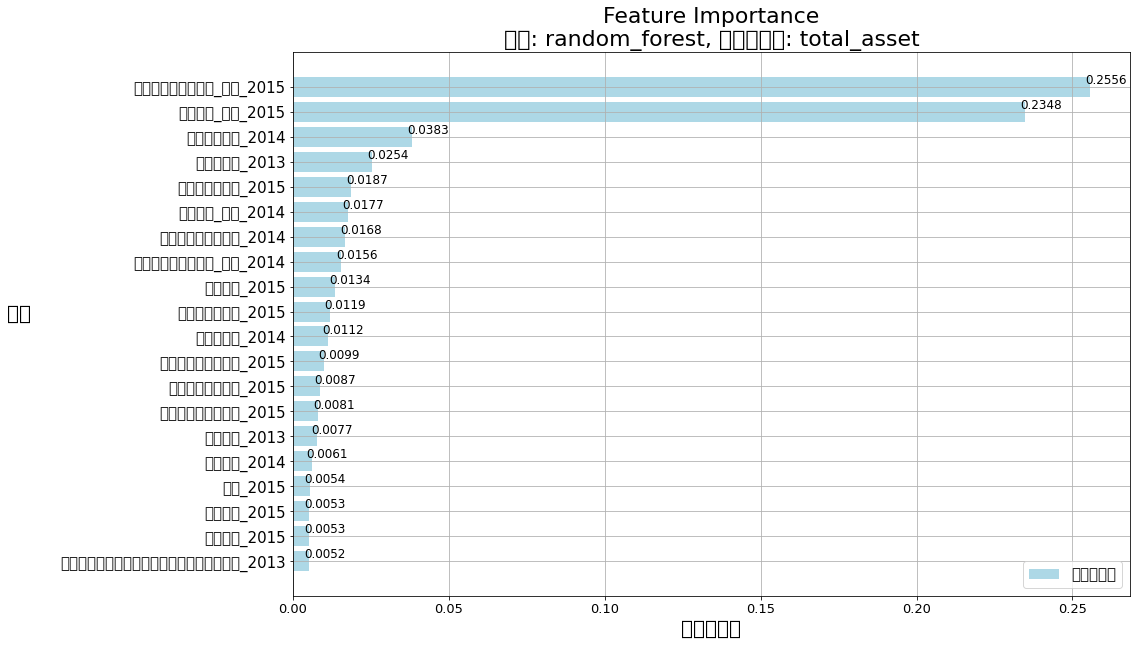

In [42]:
# 第一種模型組合的feature importance圖
rf_total_asset_feat_importance = plot_feature_importance(result, 'random_forest', 'total_asset')
rf_total_asset_result, rf_total_asset_rmse = rmse_percentile(result, 'random_forest', 'total_asset')

In [ ]:
# 從這個表可以看到第50百分位的RMSE為0.834
rf_total_asset_rmse

,rmse
第0百分位,0.000
第10百分位,0.124
第20百分位,0.270
第30百分位,0.405
第40百分位,0.583
第50百分位,0.834
第60百分位,1.110
第70百分位,1.459
第80百分位,2.083
第90百分位,3.521


In [ ]:
# 真實值和預測值, 以及每筆資料的RMSE = ((true - prediction)**2/1)**0.5
rf_total_asset_result

,index,true,prediction,rmse
0,1101 台泥_2016,1.392,1.103,0.288
1,1102 亞泥_2016,1.240,1.193,0.047
2,1103 嘉泥_2016,0.040,0.354,0.314
3,1104 環泥_2016,2.602,3.840,1.238
4,1108 幸福_2016,0.780,0.782,0.002
...,...,...,...,...
1506,9951 皇田_2016,9.880,7.210,2.670
1507,9955 佳龍_2016,-1.220,-0.856,0.364
1508,9958 世紀鋼_2016,0.386,0.760,0.374
1509,9960 邁達康_2016,-0.640,0.596,1.236


## **Feature importane & RMSE 第二個模型組合**

### **1. 標準化方法：每間公司當年度的資產負債表科目皆除以該公司當年度的資產總額, 當年度綜合損益表和現金流量表科目除以當年度的營業收入淨額, 每股盈餘相關科目(即每股盈餘_調整, 每股盈餘-完全稀釋_調整)則除以第三年末收盤價。**

### **2. 模型：xgboost。**

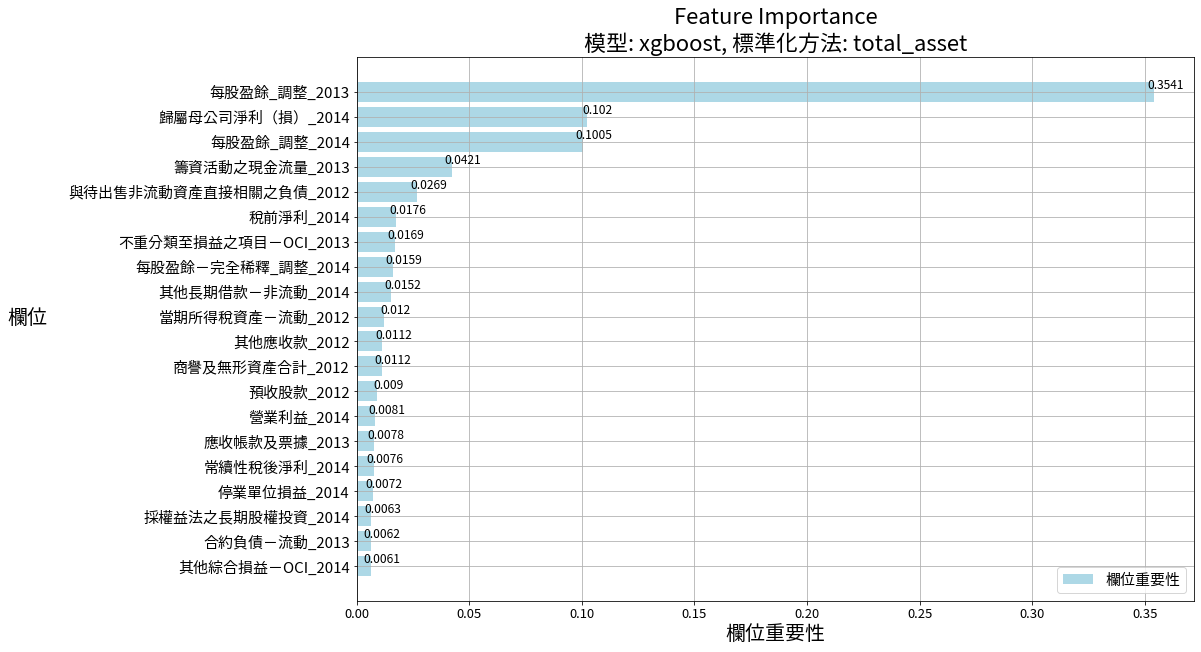

In [ ]:
# 第二種模型組合的feature importance圖
xgb_total_asset_feat_importance = plot_feature_importance(result, 'xgboost', 'total_asset')
xgb_total_asset_result, xgb_total_asset_rmse = rmse_percentile(result, 'xgboost', 'total_asset')

In [ ]:
xgb_total_asset_rmse

,rmse
第0百分位,0.000
第10百分位,0.140
第20百分位,0.336
第30百分位,0.494
第40百分位,0.687
第50百分位,0.914
第60百分位,1.213
第70百分位,1.605
第80百分位,2.215
第90百分位,3.663


## **Feature importane & RMSE 第三個模型組合**

### **1. 標準化方法：以每股為基礎, 除每股盈餘相關科目以外, 其餘科目皆除以第三年年末流通在外股數, 最後在做機器學習標準化。**

### **2. 模型：random forest。**

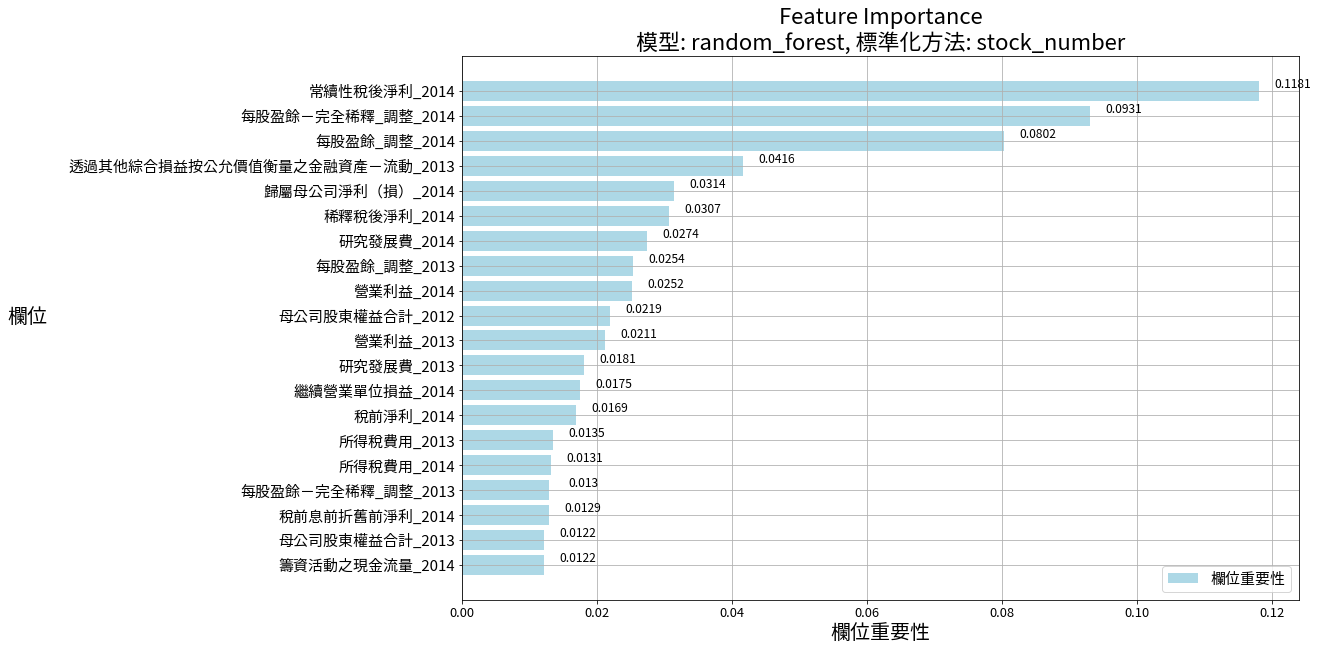

In [ ]:
# 第三種模型組合的feature importance圖
rf_stock_number_feat_importance = plot_feature_importance(result, 'random_forest', 'stock_number')
rf_stock_number_result, rf_stock_number_rmse = rmse_percentile(result, 'random_forest', 'stock_number')

In [ ]:
rf_stock_number_rmse

,rmse
第0百分位,0.000
第10百分位,0.112
第20百分位,0.238
第30百分位,0.371
第40百分位,0.538
第50百分位,0.730
第60百分位,0.976
第70百分位,1.371
第80百分位,1.893
第90百分位,3.036


## **Feature importane & RMSE 第四個模型組合**
 
### **1. 標準化方法：以每股為基礎, 除每股盈餘相關科目以外, 其餘科目皆除以第三年年末流通在外股數, 最後在做機器學習標準化。**

### **2. 模型：xgboost。**

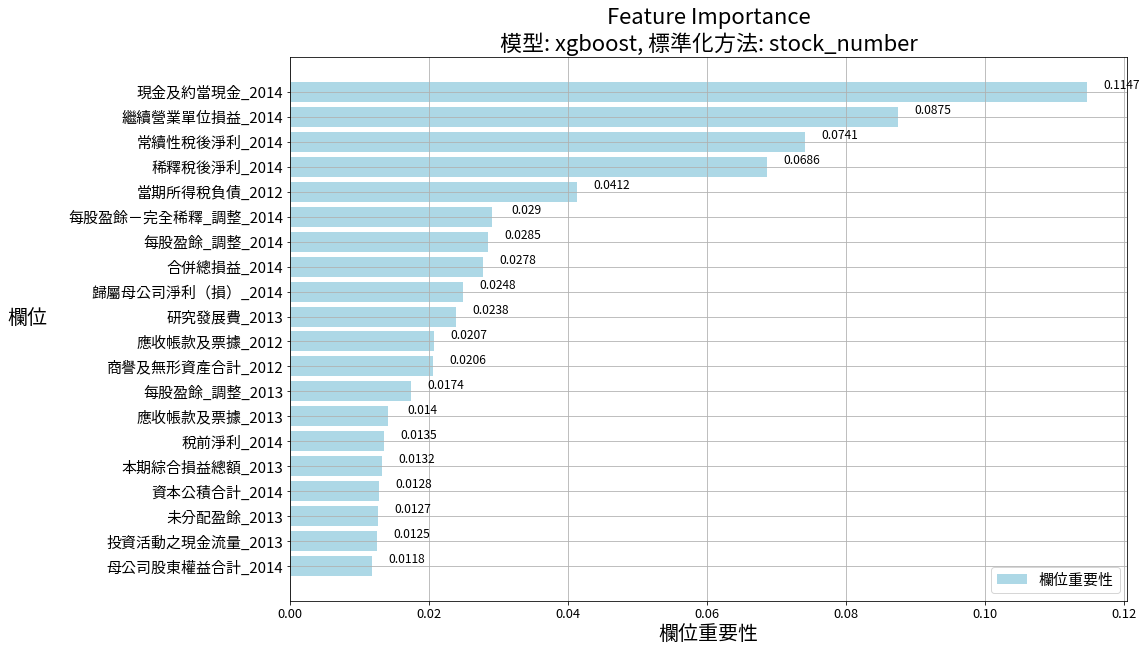

In [ ]:
# 第四種模型組合的feature importance圖
xgb_stock_number_feat_importance = plot_feature_importance(result, 'xgboost', 'stock_number')
xgb_stock_number_result, xgb_stock_number_rmse = rmse_percentile(result, 'xgboost', 'stock_number')

In [ ]:
xgb_stock_number_rmse

,rmse
第0百分位,0.000
第10百分位,0.107
第20百分位,0.225
第30百分位,0.360
第40百分位,0.549
第50百分位,0.732
第60百分位,0.994
第70百分位,1.325
第80百分位,1.824
第90百分位,2.919


# **save the result**

In [ ]:
# 將結果存成excel檔
writer = pd.ExcelWriter('./預測結果.xlsx')
sheet_name = ['rf_total_asset', 'rf_stock_number', 'xgb_total_asset', 'xgb_stock_number']
df = [rf_total_asset_result, rf_stock_number_result, xgb_total_asset_result, xgb_stock_number_result]
for i, j in zip(df, sheet_name):
  i.to_excel(writer, sheet_name=j)  
writer.save()

# **Homework**

利用三年資產負債表科目以及兩年損益表和現金流量表科目預測第四年度的調整過後稀釋每股盈餘, **需預測2017年的調整後稀釋每股盈餘(即每股盈餘-完全稀釋_調整)**, 作業要求如下所述。


------


### **1.資料時間:**


訓練和驗證資料時間 x: (會採用cross validation)
1. 2013~2015年資產負債表科目
2. 2014~2015年的綜合損益表科目
3. 2014~2015年現金流量表科目

訓練和驗證資料時間 y :
1. 2016年的調整過後的稀釋每股盈餘

測試資料時間 x: 
1. 2014～2016年資產負債表科目
2. 2015~2016年的綜合損益表科目
3. 2015~2016年現金流量表科目

測試資料時間 y :
1. 2017年的調整過後的稀釋每股盈餘


### **2.使用三種標準化方法:**

標準化方法一：

*   x: 每間公司當年度的資產負債表科目皆除以該公司當年度的資產總額, 當年度綜合損益表和現金流量表科目除以當年度的營業收入淨額, 每股盈餘相關科目(即每股盈餘_調整, 每股盈餘-完全稀釋_調整)則除以第三年末收盤價。

*   y: 每股盈餘-完全稀釋_調整需除以第三年末收盤價。

標準化方法二：
*   x: 除了每股盈餘相關科目以外(即每股盈餘_調整, 每股盈餘-完全稀釋_調整), 其餘科目皆需除以第三年年末的流通在外股數, 除完以後做機器學習標準化(減掉平均值再除標準差)。
*   y: 每股盈餘-完全稀釋_調整需做機器學習標準化。

標準化方法三：

*   x: 機器學習標準化(減掉平均值再除標準差)。

*   y: 機器學習標準化(減掉平均值再除標準差)。

Hint: 可以使用上面已經定義好的標準化function或是sklearn的standardscaler套件。

### **3. 採用兩種模型:**
1. random forest regressor。
2. xgboost regressor。

Hint: 可以使用上面已經定義好的模型function。

-------------

最終會有6組預測結果(三種標準化方法搭配兩種模型), 最終結果的呈現則需要和範例excel檔一樣, 並將2016年的預測結果(即範例excel檔)結合2017年的預測結果做分析。

     

In [22]:
data_2016 = create_data(asset_col, income_col, cash_col, eps_col, y_col, df_final, 2013, 2015, 2014, 2015)
data_2017 = create_data(asset_col, income_col, cash_col, eps_col, y_col, df_final, 2014, 2016, 2015, 2016)
data_2016 = remove_row(data_2016, year[1:4]).replace(np.nan, 0)
data_2017 = remove_row(data_2017, year[2:5]).replace(np.nan, 0)

result = {'random_forest':{'total_asset':{}, 'stock_number':{}},
          'xgboost':{'total_asset':{}, 'stock_number':{}}}
rf_param = {"n_estimators":[250, 500], "max_depth":[6, 7], "random_state":[1], "n_jobs":[-1], "verbose":[0]}
xgb_param = {"n_estimators":[250, 500], "max_depth":[6, 7], "learning_rate":[0.05, 0.1, 0.2], "objective":['reg:squarederror'], "random_state":[1], "verbosity":[0]}
rf_param_pipe = {"rf__n_estimators":[250, 500], "rf__max_depth":[6, 7], "rf__random_state":[1], "rf__n_jobs":[-1], "rf__verbose":[0]}
xgb_param_pipe = {"xgb__n_estimators":[250, 500], "xgb__max_depth":[6, 7], "xgb__learning_rate":[0.05, 0.1, 0.2], "xgb__objective":['reg:squarederror'], "xgb__random_state":[1], "xgb__verbosity":[0]}

In [23]:
# 標準化方法一
df_2016 = divide_total_asset(data_2016, asset_col, income_col, cash_col, eps_col, y_col, year[1:5])
df_2017 = divide_total_asset(data_2017, asset_col, income_col, cash_col, eps_col, y_col, year[2:6])
test_price = data_2017[('收盤價(元)', '2016-12-30')]

random_forest(df_2016, df_2017, rf_param, result, 'total_asset', test_price=test_price)
xgboost(df_2016, df_2017, xgb_param, result, 'total_asset', test_price=test_price)

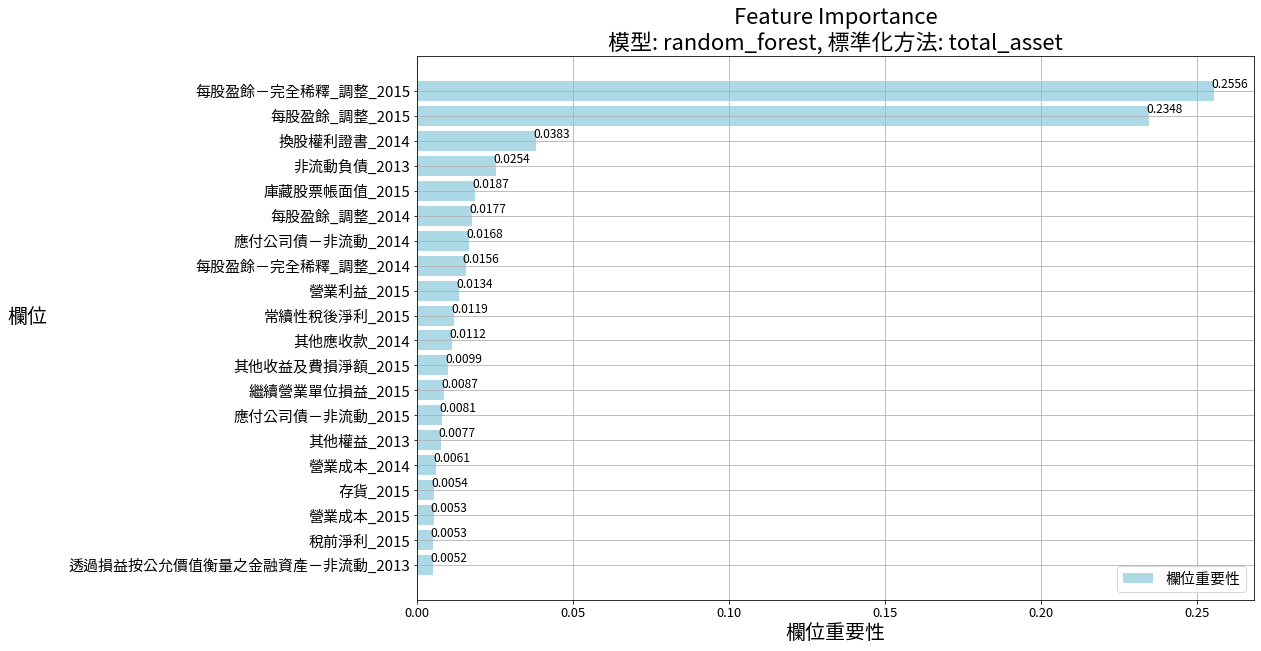

In [27]:
rf_total_asset_feat_importance = plot_feature_importance(result, 'random_forest', 'total_asset')
rf_total_asset_result, rf_total_asset_rmse = rmse_percentile(result, 'random_forest', 'total_asset')

In [29]:
rf_total_asset_rmse

,rmse
第0百分位,0.000
第10百分位,0.134
第20百分位,0.263
第30百分位,0.389
第40百分位,0.541
第50百分位,0.795
第60百分位,1.083
第70百分位,1.483
第80百分位,2.048
第90百分位,3.458


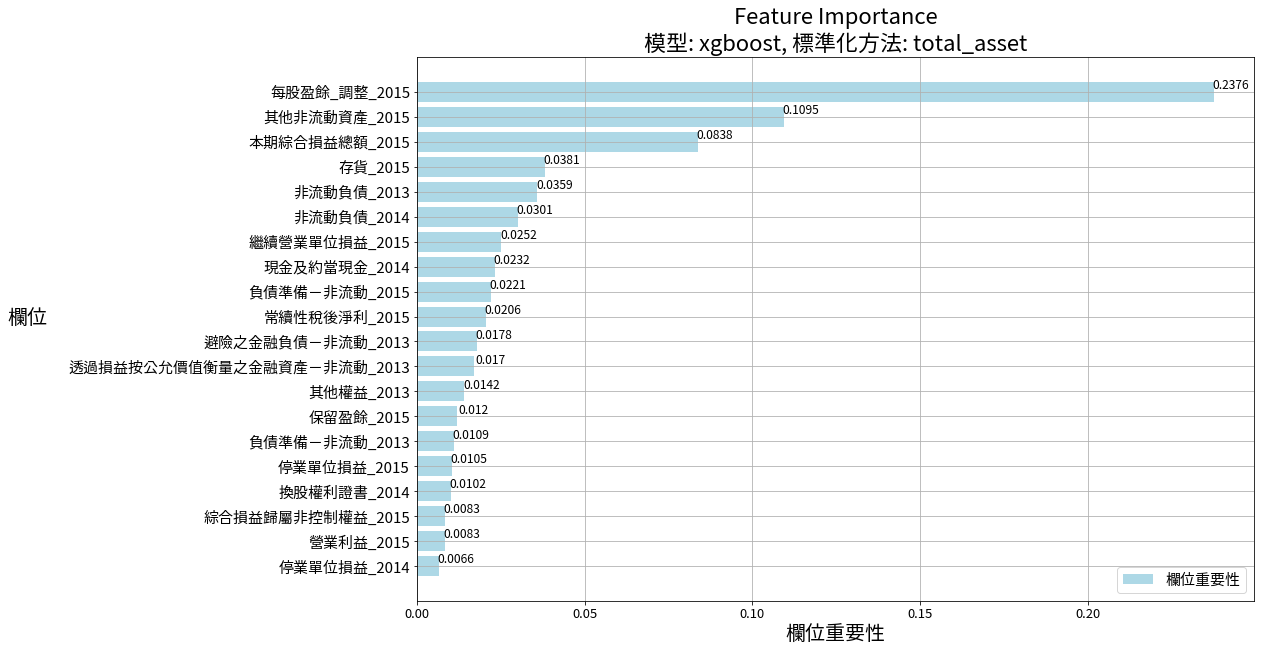

In [30]:
xgb_total_asset_feat_importance = plot_feature_importance(result, 'xgboost', 'total_asset')
xgb_total_asset_result, xgb_total_asset_rmse = rmse_percentile(result, 'xgboost', 'total_asset')

In [31]:
xgb_total_asset_rmse

,rmse
第0百分位,0.000
第10百分位,0.133
第20百分位,0.295
第30百分位,0.464
第40百分位,0.656
第50百分位,0.900
第60百分位,1.215
第70百分位,1.636
第80百分位,2.410
第90百分位,3.556


In [32]:
# 標準化方法二
df_2016 =  divide_stock_number(data_2016, eps_col)
df_2017 = divide_stock_number(data_2017, eps_col)

random_forest(df_2016, df_2017, rf_param_pipe, result, 'stock_number')
xgboost(df_2016, df_2017, xgb_param_pipe, result, 'stock_number')

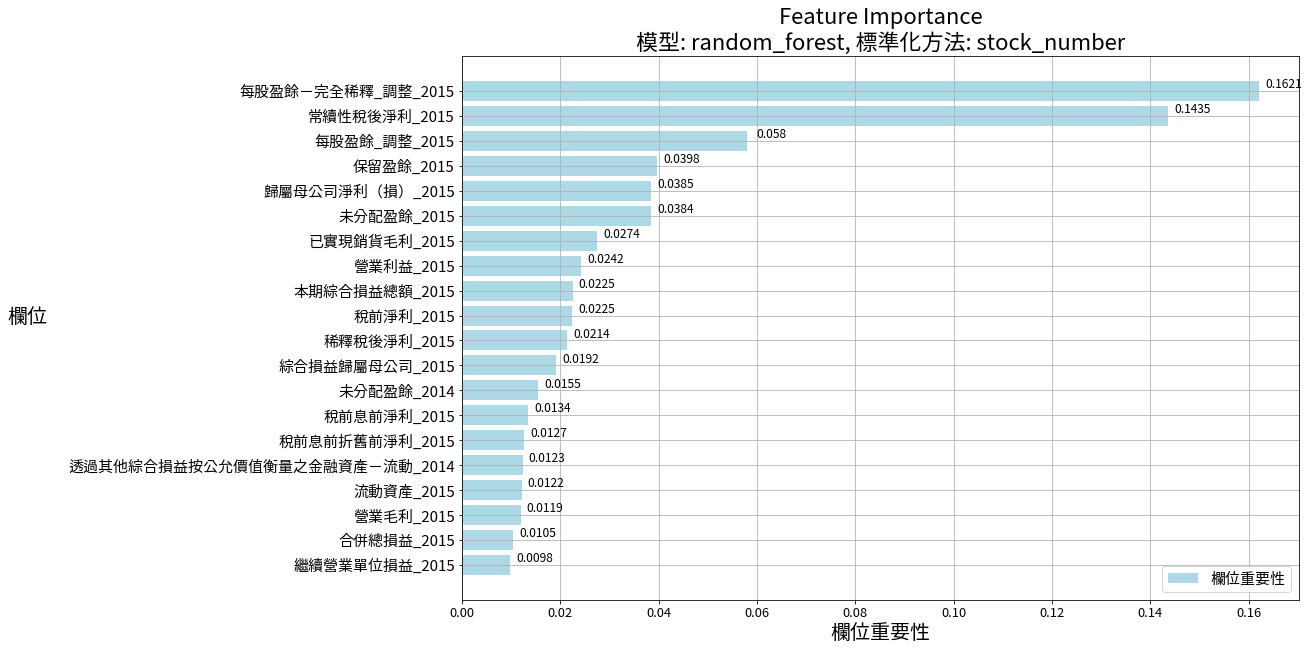

In [33]:
rf_stock_number_feat_importance = plot_feature_importance(result, 'random_forest', 'stock_number')
rf_stock_number_result, rf_stock_number_rmse = rmse_percentile(result, 'random_forest', 'stock_number')

In [34]:
rf_stock_number_rmse

,rmse
第0百分位,0.000
第10百分位,0.123
第20百分位,0.253
第30百分位,0.370
第40百分位,0.513
第50百分位,0.710
第60百分位,0.971
第70百分位,1.381
第80百分位,1.987
第90百分位,3.164


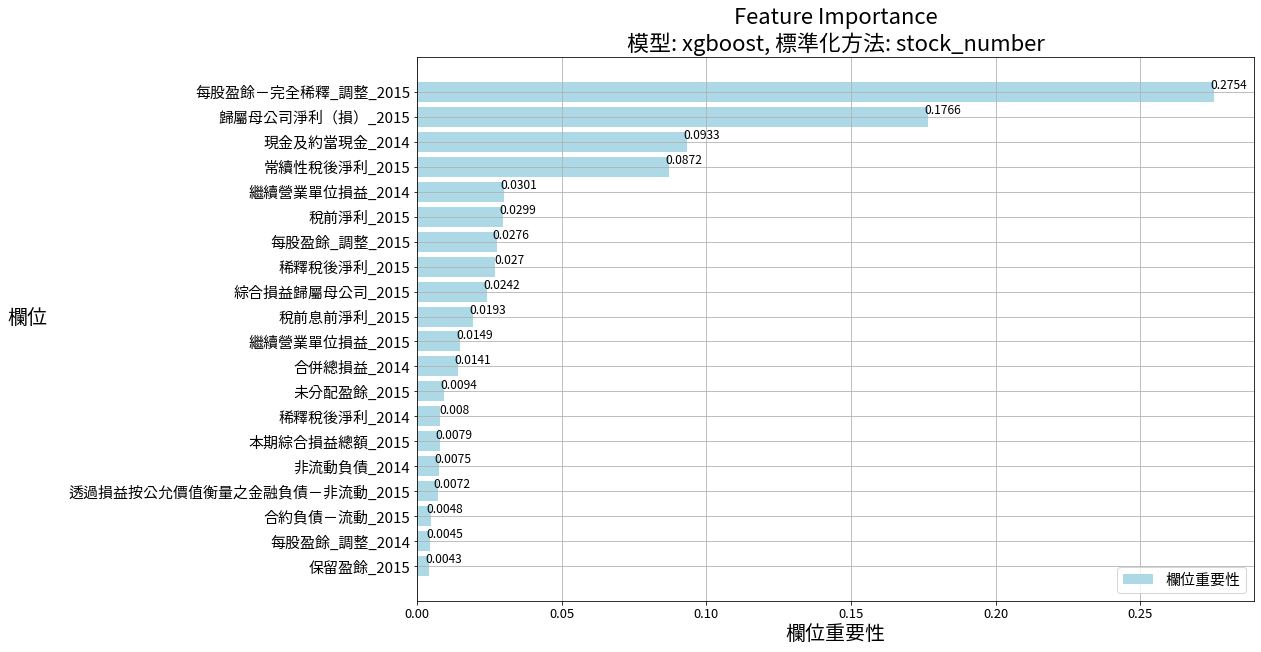

In [35]:
xgb_stock_number_feat_importance = plot_feature_importance(result, 'xgboost', 'stock_number')
xgb_stock_number_result, xgb_stock_number_rmse = rmse_percentile(result, 'xgboost', 'stock_number')

In [36]:
xgb_stock_number_rmse

,rmse
第0百分位,0.002
第10百分位,0.150
第20百分位,0.279
第30百分位,0.410
第40百分位,0.583
第50百分位,0.803
第60百分位,1.097
第70百分位,1.470
第80百分位,2.086
第90百分位,3.489


In [48]:
# 標準化方法三
result_3 = {'random_forest':{'total_asset':{}, 'stock_number':{}, 'Stand':{}},
          'xgboost':{'total_asset':{}, 'stock_number':{}, 'Stand':{}}}

df_2016 = data_2016
df_2017 = data_2017

random_forest(df_2016, df_2017, rf_param_pipe, result_3, 'Stand')
xgboost(df_2016, df_2017, xgb_param_pipe, result_3, 'Stand')

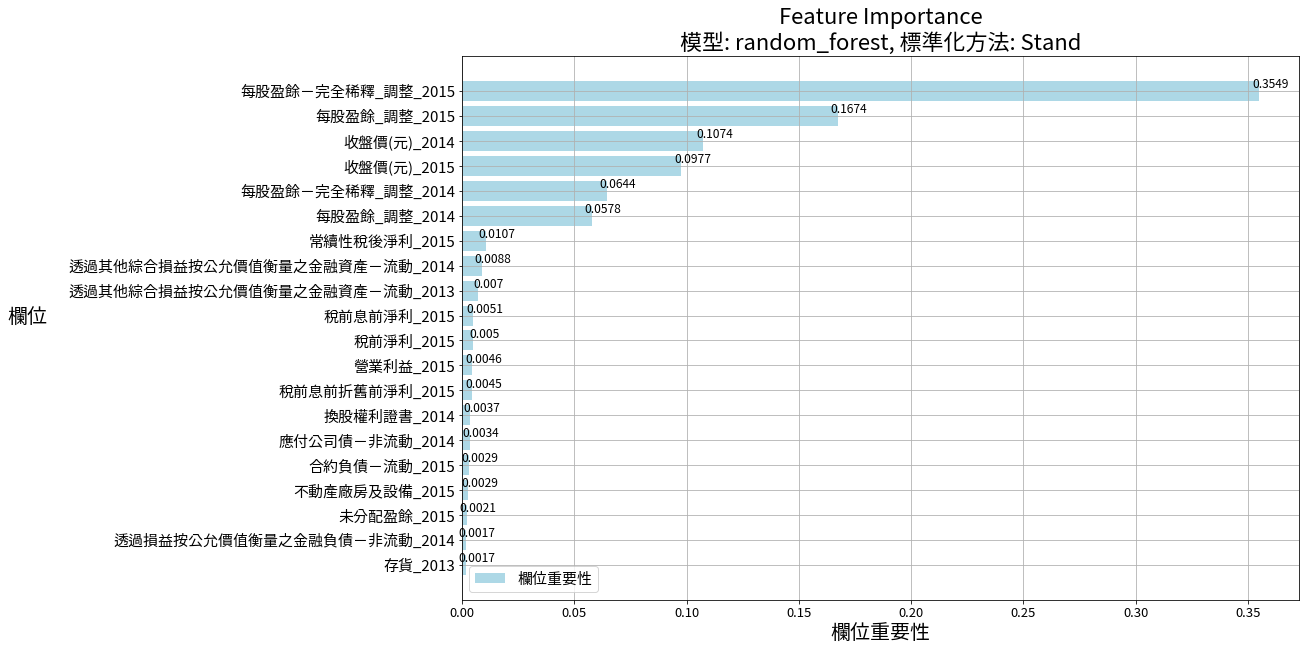

In [45]:
rf_Stand_feat_importance = plot_feature_importance(result_3, 'random_forest', 'Stand')
rf_Stand_result, rf_Stand_rmse = rmse_percentile(result_3, 'random_forest', 'Stand')

In [47]:
rf_Stand_rmse

,rmse
第0百分位,0.000
第10百分位,0.120
第20百分位,0.254
第30百分位,0.380
第40百分位,0.529
第50百分位,0.730
第60百分位,1.011
第70百分位,1.344
第80百分位,1.953
第90百分位,3.325


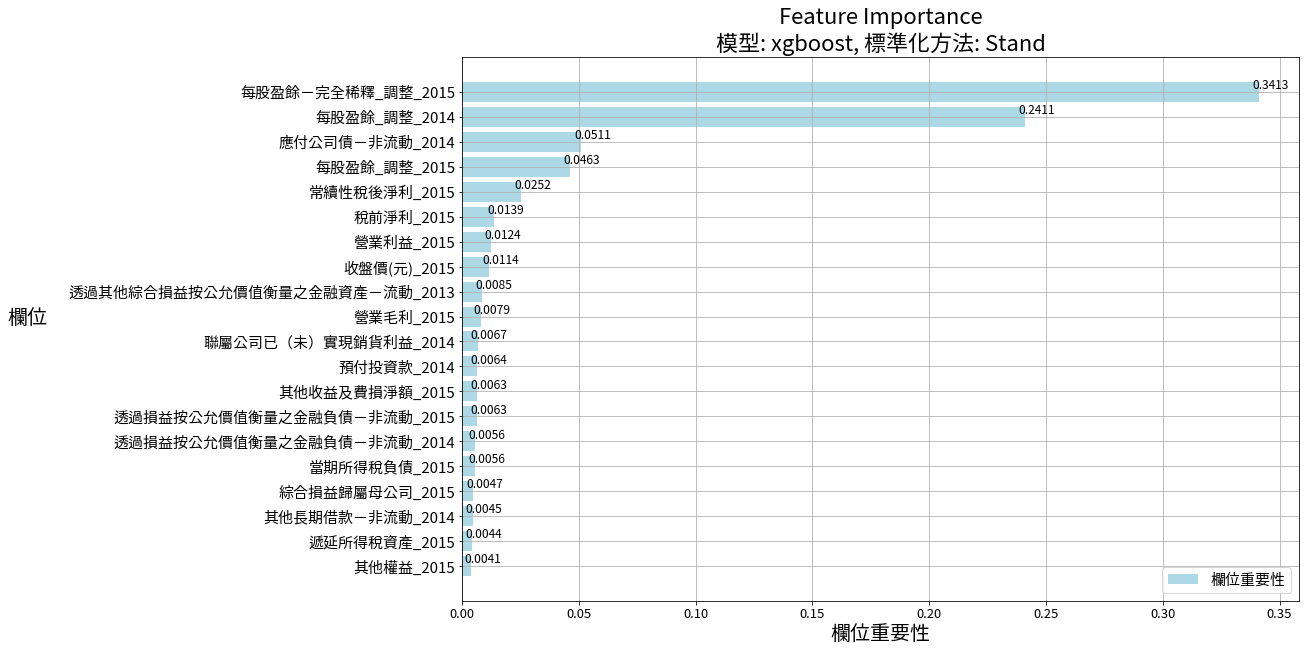

In [49]:
xgb_Stand_feat_importance = plot_feature_importance(result_3, 'xgboost', 'Stand')
xgb_Stand_result, xgb_Stand_rmse = rmse_percentile(result_3, 'xgboost', 'Stand')

In [50]:
xgb_Stand_rmse

,rmse
第0百分位,0.000
第10百分位,0.137
第20百分位,0.253
第30百分位,0.400
第40百分位,0.568
第50百分位,0.777
第60百分位,1.025
第70百分位,1.404
第80百分位,2.061
第90百分位,3.357


In [51]:
# 將結果存成excel檔
writer = pd.ExcelWriter('./預測結果.xlsx')
sheet_name = ['rf_total_asset', 'rf_stock_number', 'rf_Stand', 'xgb_total_asset', 'xgb_stock_number', 'xgb_Stand']
df = [rf_total_asset_result, rf_stock_number_result, rf_Stand_result, xgb_total_asset_result, xgb_stock_number_result, xgb_Stand_result]
for i, j in zip(df, sheet_name):
  i.to_excel(writer, sheet_name=j)  
writer.save()